# Doc 3 EV Regenerative Braking

## 1 Raw data processing

In [1]:
import os
import pandas as pd
import numpy as np
from trajtool import TrajTool
tt = TrajTool()

### 1.1 Load data

Vehicle specification

In [2]:
veh_info = pd.read_excel('data/ev records/veh_info.xlsx')
veh_info

,model,brand,class,fuel,shape,weight/kg,width/mm,height/mm,coef_roll,coef_aero,delta_aero_window_open
0,Ei5,Roewe,A,EV,wagon,1560,1818,1543,0.0105,0.30,0.04
1,ModelY,Tesla,SUV,EV,SUV,1911,1921,1624,0.0105,0.23,0.06


Trajectory

In [22]:
read_paths = [
    'data/ev records/raw/Ei5/DRIVER1/',
    'data/ev records/raw/Ei5/DRIVER2/',
    'data/ev records/raw/ModelY/DRIVER1/',
    'data/ev records/raw/ModelY/DRIVER2/',
    ]

In [54]:
data_dict = {}
for read_path in read_paths:
    cali_file, meteoro_file, record_file = os.listdir(read_path)
    model, driver = read_path.split('/')[3:5]
    key = model + '-' + driver  # model-driverID
    data_dict[key] = {
        'cali': pd.read_csv(read_path + cali_file, sep=" "),
        'record': pd.read_csv(read_path + record_file, sep=" "),
        'meteo': pd.read_csv(read_path + meteoro_file, sep=" "),
        'model': model,
        'driver': driver
    }

### 1.2 Processing and calculation

Meteorology

In [55]:
def meteo_process(meteo:pd.DataFrame):
    """
    Processing meteorology data.
    """
    meteo = meteo.copy()
    # densify
    meteo = tt.encode_time(meteo, 'UTC', 'sec of day', '%H%M%S', 'sec of day')
    new_index = np.arange(meteo['sec of day'].min(), meteo['sec of day'].max() + 1)
    meteo = meteo.set_index('sec of day')
    meteo = meteo.reindex(new_index, method='pad')
    # select columns
    meteo = meteo[meteo.columns[[1, 2, 3, 4, 6]]]
    meteo.columns = ['temp[C]', 'humd', 'pressure[hPa]', 'v_wind[km/h]', 'd_wind[D]']
    meteo['humd'] = meteo['humd'].apply(lambda x: x/100)
    return meteo

for key in data_dict.keys():
    data_dict[key]['meteo'] = meteo_process(data_dict[key]['meteo'])

Trajecotry

In [56]:
def cal_roll_force(mass, theta, coef_roll=0.0105):
    """
    Calculate the rolling force.
    mass: vehicle mass (kg)
    theta: road elevation angle (degree)
    coef_roll: rolling resistance coefficient
    """
    g = 9.81 # m/s2
    return coef_roll * mass * g * np.cos(np.radians(theta))

def cal_aero_force(p, t, h, v, v_wind, d_wind, tn_v, width, height, coef_aero):
    """
    Calculate the aerodynamic drag.
    p: ambient air pressure (hPa)
    t: ambient air temperature (℃)
    h: relative humidity (0.0-1.0)
    v: vehicle speed (km/h)
    v_wind: wind speed (km/h)
    tn_v: true north of vehicle direction (degree)
    d_wind: direction from which the wind originates (degree)
    width: width of the frontal area of the vehicle (mm)
    height: height of the frontal area of the vehicle (mm)
    coef_aero: coefficient of aerodynamic drag
    """
    p = p * 100 # hPa to Pa
    R_d = 287.058  # specific gas content of dry air, J/kg/K
    R_v = 461.495  # specific gas content of water vapor, J/kg/K
    p_v = h * (0.61078 * np.exp(17.27 * t / (t + 235.3))) * 1000 # water vapor pressure (Pa)
    air_density = p_v / (R_v * (t + 273.15)) + (p - p_v) / (R_d * (t + 273.15)) # kg/m3
    v_w = v_wind * np.cos(np.radians(tn_v) - np.radians(d_wind)) # km/h
    return 0.5 * air_density * coef_aero * (width/1000) * (height/1000) * ((v + v_w) * 5 / 18)**2

def cal_grad_force(mass, theta):
    """
    Calcualte the grading resistance.
    mass: vehicle mass (kg)
    theta: road elevation angle (degree)
    """
    g = 9.81
    return mass * g * np.sin(np.radians(theta))

def cal_acce_force(mass, a):
    """
    Calculate acceleration resistance.
    mass: vehicle mass (kg)
    a: acceleration (m/s2)
    """
    return mass * a

def cal_trac_power(mass, width, height, theta, v, a, tn_v, p, t, h, v_wind, d_wind, coef_aero, coef_roll=0.0105):
    """
    Calculate tractive power.
    ----------
    mass: vehicle mass (kg)
    width: width of the frontal area of the vehicle (m)
    height: height of the frontal area of the vehicle (m)
    theta: road elevation angle (degree)
    v: vehicle speed (km/h)
    a: acceleration (m/s2)
    tn_v: true north of vehicle direction (degree)
    p: ambient air pressure (hPa)
    t: ambient air temperature (℃)
    h: relative humidity (0.0-1.0)
    v_wind: wind speed (km/h)
    d_wind: direction from which the wind originates (degree)
    coef_aero: coefficient of aerodynamic drag
    coef_roll: rolling resistance coefficient
    ----------
    output: tractive power [kW]
    """
    trac_force = cal_roll_force(mass, theta, coef_roll) \
               + cal_aero_force(p, t, h, v, v_wind, d_wind, tn_v, width, height, coef_aero) \
               + cal_grad_force(mass, theta) \
               + cal_acce_force(mass, a)
    return trac_force * v * 5 / 18 / 1000

In [57]:
def record_process(record:pd.DataFrame, meteo:pd.DataFrame, veh:pd.DataFrame):
    """
    Processing trajectory data.
    """
    record = record.copy()
    # clean
    record['Digi_output'] = record['Digi_output'].shift(4)
    record.dropna(inplace=True)
    record.reset_index(drop=True, inplace=True)
    # encode time 
    record['UTC'] = record['UTC'].astype('int')
    record['UTC'] = record['UTC'].astype('str')
    record = tt.encode_time(record, 'UTC', 'sec of day', '%H%M%S', 'sec of day')
    record['sec'] = record['sec of day'].apply(lambda x: x-record['sec of day'].min())
    # densify
    record = tt.densify(record, 'Lon', 'Lat', 'sec')
    # smooth
    record = tt.smooth_traj(record, 'Lon', 'Lat', 'sec', 'lon', 'lat', smoothFunc='kal2D', measure_var = 0.000001, process_var=0.000001)
    record = tt.smooth(record, 'Speed', 'speed', smoothFunc='exp')
    record = tt.smooth(record, 'Alt', 'alt', smoothFunc='exp')
    record = tt.smooth(record, 'TNH', 'heading', smoothFunc='exp')
    record = tt.smooth(record, 'Digi_output', 'pad_pressure', smoothFunc='moving')
    record['pad_pressure'] = record['pad_pressure'].apply(np.floor)
    record = record[['sec','sec of day','lon','lat','speed','alt','heading','pad_pressure']]
    # data type transform
    record['sec'] = record['sec'].astype('int16')
    record['speed'] = record['speed'].astype('float16')
    record['alt'] = record['alt'].astype('float16')
    record['heading'] = record['heading'].astype('float16')
    record['pad_pressure'] = record['pad_pressure'].astype('int16')
    # calculate
    record = tt.cal_interval(record, 'lon', 'lat', 'sec', 'd_gap[m]', 't_gap[s]')
    record = tt.cal_grade(record, 'lon', 'lat', 'd_gap[m]', eleCol='alt')
    record = tt.cal_acc(record, 't_gap[s]', 'speed', 'acc[m/s2]')
    record = tt.cal_VSP(record, 'speed', 'acc[m/s2]', 'VSP[kW/t]', 'grade[D]')
    record.dropna(inplace=True)
    record.reset_index(drop=True, inplace=True)
    # data type transform
    record['acc[m/s2]'] = record['acc[m/s2]'].astype('float16')
    record['VSP[kW/t]'] = record['VSP[kW/t]'].astype('float16')
    record['grade[D]'] = record['grade[D]'].astype('float16')
    # merge data
    data = record.set_index('sec of day').join(meteo)
    data.reset_index(inplace=True, names=['sec of day'])
    data.rename(
        columns={
            'speed': 'speed[km/h]',
            'alt': 'alt[m]',
            'heading': 'true_north[D]'
        }, inplace=True)
    # tractive power
    data['trac_power[kW]'] = data.apply(lambda x:
        cal_trac_power(
            veh['weight/kg']+60*2, veh['width/mm'], veh['height/mm'],
            theta=x['grade[D]'], v=x['speed[km/h]'], a=x['acc[m/s2]'], tn_v=x['true_north[D]'],
            p=x['pressure[hPa]'], t=x['temp[C]'], h=x['humd'], v_wind=x['v_wind[km/h]'], d_wind=x['d_wind[D]'],
            coef_aero=veh['coef_aero']+veh['delta_aero_window_open'], coef_roll=veh['coef_roll']
        ),
        axis=1
    )
    data['trac_power[kW]'] = data['trac_power[kW]'].astype('float16')
    return data

In [58]:
for key in data_dict.keys():
    # meteorology data
    meteo = data_dict[key]['meteo']
    # vehicle information
    veh = veh_info[veh_info['model'] == data_dict[key]['model']]
    # trajectory records
    data_dict[key]['record'] = record_process(data_dict[key]['record'], meteo, veh)

- densified length: 3628;
- densified ratio: 114.38%.
- densified length: 3250;
- densified ratio: 114.44%.
- densified length: 3760;
- densified ratio: 114.74%.
- densified length: 3275;
- densified ratio: 114.71%.


Saving

In [ ]:
# for key in data_dict.keys():
#     data_dict[key]['record'].to_csv('data/ev records/processed/%s-%s.csv' % (data_dict[key]['model'], data_dict[key]['driver']), index=False)

---

## 2 Braking Extraction

### 2.1 Loading

In [79]:
# file names
read_path = 'data/ev records/processed/'
traj_files = os.listdir(read_path)

# read trajectory
trajs = {}
for traj_file in traj_files:
    key = traj_file.split('.')[0]
    trajs[key] = pd.read_csv(read_path + traj_file)

### 2.2 Braking extraction

How to detect braking, regenerative braking from deceleration?
- Criteria for deceleration:
  - `Acc` < 0
- Criteria for braking:
  - `Tractive Power` < 0
- Criteria for regenerative braking (EV):
  - `Tractive Power` < 0
  - `Brake Pad Signal` > static signal

In [80]:
from calculator import ERCalculator
cal = ERCalculator()

In [92]:
# initialize
traj_braking = pd.DataFrame({})
# iterate
for key, traj_raw in trajs.items():
    traj = traj_raw.copy()
    traj = traj[['sec of day', 'lon', 'lat', 'speed[km/h]', 'acc[m/s2]', 'VSP[kW/t]', 'trac_power[kW]', 'pad_pressure', 'true_north[D]', 'grade[D]']]
    # detect braking
    traj['braking'] = traj['trac_power[kW]'].apply(lambda x: 1 if x < 0 else 0)
    # detect regenerative braking
    traj['reg_braking'] = 0
    traj.loc[
        ((traj['braking'] == 1) &
        (traj['pad_pressure'] < 5)),  # set 5 as the threshold of braking signal
        'reg_braking'] = 1
    # veh type and driver
    veh, driver = key.split("-")
    traj['model'] = veh
    traj['driver'] = driver
    # merge
    traj_braking = pd.concat([traj_braking, traj])

traj_braking.reset_index(drop=True, inplace=True)

### 2.3 Merge vehicle specification

In [82]:
veh_info = pd.read_excel('data/ev records/veh_info.xlsx')
traj_braking_vehinfo = pd.merge(traj_braking, veh_info[["model", "brand"]], on="model", how="left")
traj_braking_vehinfo.head()

,sec of day,lon,lat,speed[km/h],acc[m/s2],VSP[kW/t],trac_power[kW],pad_pressure,true_north[D],grade[D],braking,reg_braking,model,driver,brand
0,52857.0,118.819359,31.895989,0.0,0.0,0.0,0.0,4,0.0,0.0000,False,0,Ei5,DRIVER1,Roewe
1,52858.0,118.819359,31.895989,0.0,0.0,0.0,0.0,3,0.0,0.0000,False,0,Ei5,DRIVER1,Roewe
2,52859.0,118.819359,31.895989,0.0,0.0,0.0,0.0,2,0.0,0.0000,False,0,Ei5,DRIVER1,Roewe
3,52860.0,118.819359,31.895989,0.0,0.0,0.0,0.0,1,0.0,0.0000,False,0,Ei5,DRIVER1,Roewe
4,52861.0,118.819359,31.895989,0.0,0.0,0.0,0.0,1,0.0,0.8745,False,0,Ei5,DRIVER1,Roewe


In [ ]:
# traj_braking_vehinfo.to_csv('data/ev records/traj_braking.csv', index=False)

---

## 3 Exploration

In [7]:
traj_braking_vehinfo = pd.read_csv('data/ev records/traj_braking.csv')

### 3.1 Description

In [83]:
# duration
traj_braking_vehinfo.groupby(['model']).size()

model
Ei5       6876
ModelY    7033
dtype: int64

In [84]:
# mileage
traj_braking_vehinfo.groupby(['model']).apply(lambda x: tt.cal_mileage(x, 'lon', 'lat'))

model
Ei5       {0: 72776.14449039972}
ModelY    {0: 72973.20518068559}
dtype: object

In [94]:
# braking duration
traj_braking_vehinfo.groupby(['model']).apply(lambda x: x[x['braking'] == 1].shape[0])

model
Ei5       1776
ModelY    1814
dtype: int64

In [95]:
# reg braking duration
traj_braking_vehinfo.groupby(['model']).apply(lambda x: x[x['reg_braking'] == 1].shape[0])

model
Ei5        774
ModelY    1786
dtype: int64

In [87]:
# fraction of regenerative braking
traj_braking_vehinfo.groupby(['model']).apply(lambda x: x[x['reg_braking'] == 1].shape[0] / x[x['braking'] == 1].shape[0])

model
Ei5       0.476656
ModelY    0.985445
dtype: float64

### 3.2 Profile

In [40]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt

In [41]:
import matplotlib.cm as cm
set2_colors = cm.get_cmap('Set2')
braking_color = set2_colors(0)
reg_braking_color = set2_colors(1)

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_15644\1397093597.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_colors = cm.get_cmap('Set2')


In [42]:
def plot_traj(traj: pd.DataFrame, key: str):
    fig, ax = plt.subplots(1,1, figsize=(15,3))
    ax.stairs(traj['speed[km/h]'], color='grey', linewidth=0.5, fill=True, alpha=1.0, label="speed [km/h]")
    ax.set_title(key)
    ax.set_xlim(0, 3600)
    ax.set_ylim(0,120)
    ax.legend()

In [43]:
def plot_traj(traj: pd.DataFrame, key: str):
    fig, ax1 = plt.subplots(1, 1, figsize=(9,2.5))
    
    # speed profile
    ax1.stairs(traj['speed[km/h]'], color='grey', linewidth=0.5, fill=True, alpha=1.0, label="speed [km/h]")
    ax1.set_title(key, loc='right')
    # ax1.set_xlim(0, 3600)
    ax1.set_ylim(0, 115)
    ax1.set_ylabel('Speed (km/h)')
    ax1.set_xlabel('Timestamp (s)')
    ax1.legend(loc='upper left')
    
    # braking signal
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 2)
    ax2.set_yticks([1])
    ax2.set_yticklabels(['ON'])
    ax2.set_ylabel('Braking Status')
    
    # braking
    ax2.stairs(traj['braking'], color=braking_color, linewidth=1.0, alpha=0.7, fill=True, label='conventional braking')
    
    # reg_braking
    ax2.stairs(traj['reg_braking'], color=reg_braking_color, linewidth=1.0, alpha=0.7, fill=True, label='regenerative braking')
    
    # 合并两个图例
    # lines1, labels1 = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', ncol=2)
    ax2.legend(loc='upper right', ncol=1)
    
    plt.tight_layout()
    plt.show()
    fig.savefig('figures/road_test_speed_profile_%s.jpg' % key, bbox_inches='tight', dpi=1000)

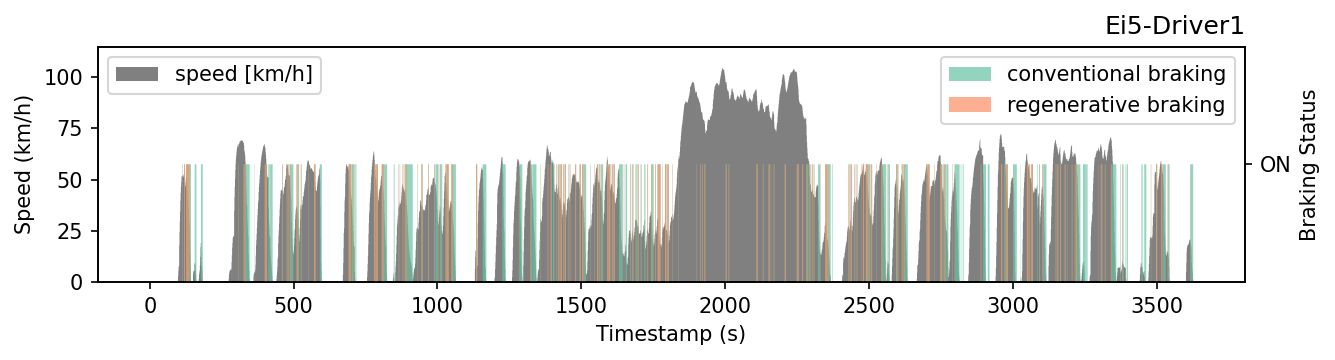

In [44]:
plot_traj(traj_braking_vehinfo[(traj_braking_vehinfo['model'] == 'Ei5') & (traj_braking_vehinfo['driver'] == 'DRIVER1')], 'Ei5-Driver1')

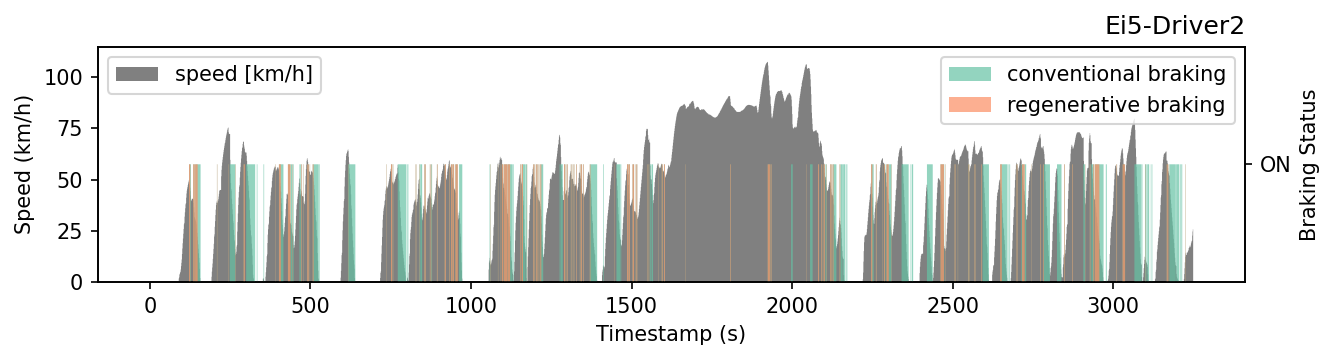

In [27]:
plot_traj(traj_braking_vehinfo[(traj_braking_vehinfo['model'] == 'Ei5') & (traj_braking_vehinfo['driver'] == 'DRIVER2')], 'Ei5-Driver2')

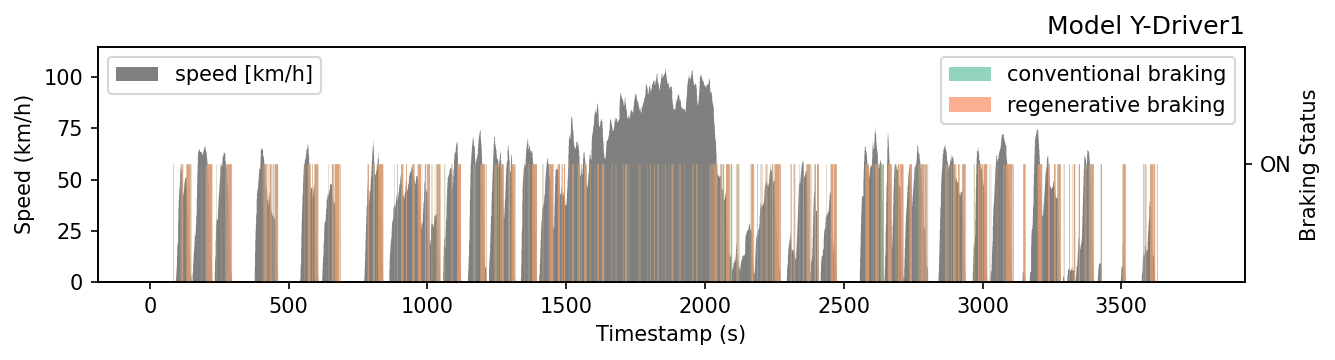

In [28]:
plot_traj(traj_braking_vehinfo[(traj_braking_vehinfo['model'] == 'ModelY') & (traj_braking_vehinfo['driver'] == 'DRIVER1')], 'Model Y-Driver1')

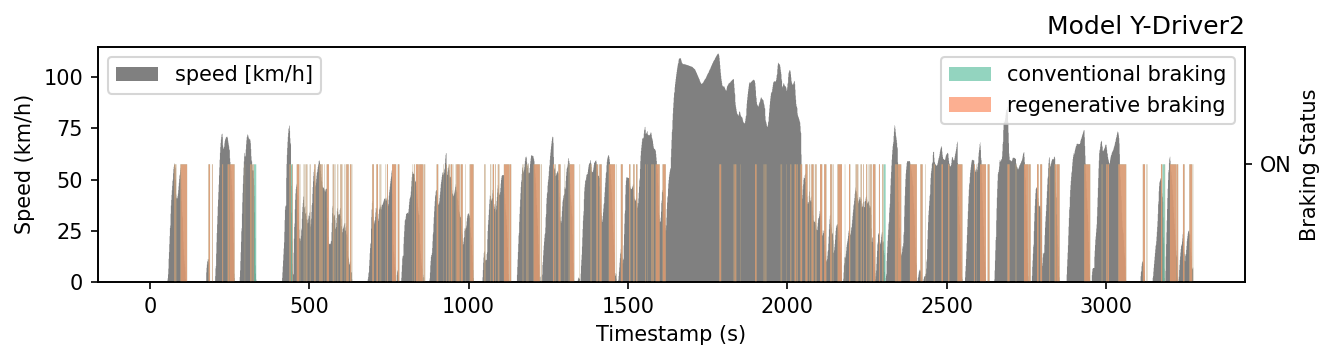

In [29]:
plot_traj(traj_braking_vehinfo[(traj_braking_vehinfo['model'] == 'ModelY') & (traj_braking_vehinfo['driver'] == 'DRIVER2')], 'Model Y-Driver2')

### 3.3 Map

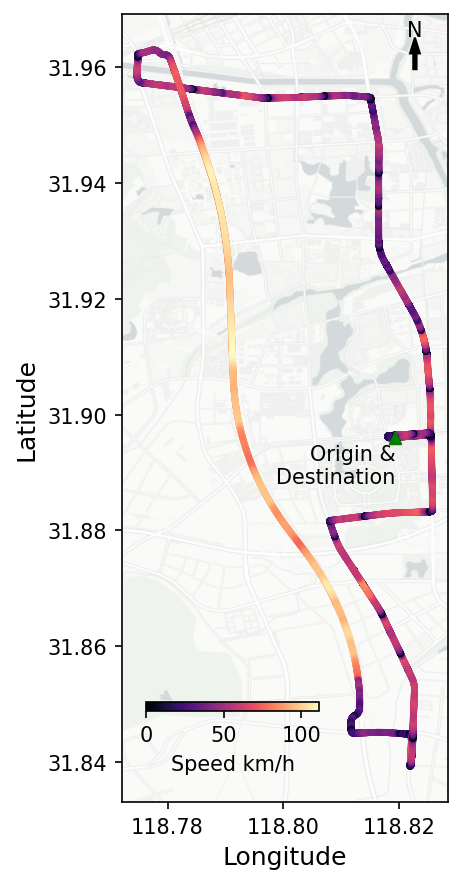

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,6))

# transfer to geodataframe
all_gdfs = []
for key, df in trajs.items():
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))
    gdf.crs = 'EPSG:4326'
    all_gdfs.append(gdf)
combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdfs, ignore_index=True))

# plot speed
im = combined_gdf.plot(
    ax=ax, column='speed[km/h]', markersize=5, alpha=0.8, cmap='magma',
    legend=True, legend_kwds={
        'location':'bottom', 'orientation':'horizontal',
        'shrink':0.4,
        'fraction':0.1, 'pad':-0.1, 'anchor':(0.3,1.3), 
        'ticks':[0,50,100],
})
cbar = im.get_figure().axes[-1]
cbar.set_xlabel('Speed km/h')

# start point and end point
first_trajectory = all_gdfs[0]
start_point = first_trajectory.iloc[0]
ax.scatter(start_point.geometry.x, start_point.geometry.y, marker='^', color='green', s=30)
ax.text(start_point.geometry.x, start_point.geometry.y-0.001, 'Origin &\nDestination', fontsize=10, color='black',
         horizontalalignment='right', verticalalignment='top')

# basemap
ctx.add_basemap(ax, crs=combined_gdf.crs.to_string(), source="https://d.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png")

# arrow
def add_north_arrow(ax, x, y, arrow_length, text='N', text_offset=0.03):
    ax.arrow(x, y, 0, arrow_length, transform=ax.transAxes,
             facecolor='black', edgecolor='black', width=0.01, head_width=0.03, head_length=0.02)
    ax.text(x, y + arrow_length + text_offset, text, transform=ax.transAxes,
            ha='center', va='center', fontsize=10)
add_north_arrow(ax, 0.9, 0.93, 0.02)

# axis
ax.set_xticks([118.78, 118.80, 118.82])
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('figures/road_test_map.jpg', bbox_inches='tight', dpi=1000)

---

## 4 OpMode RB intensity

In [2]:
from calculator import ERCalculator
cal = ERCalculator()

In [3]:
# copy trajs
traj_braking_vehinfo = pd.read_csv('data/ev records/traj_braking.csv')
traj_ei5 = traj_braking_vehinfo[traj_braking_vehinfo['model'] == 'Ei5'].copy().reset_index(drop=True)
traj_modelY = traj_braking_vehinfo[traj_braking_vehinfo['model'] == 'ModelY'].copy().reset_index(drop=True)

In [4]:
# detect operating mode
traj_ei5 = cal.OpModeDetect(traj_ei5)
traj_modelY = cal.OpModeDetect(traj_modelY)

In [5]:
# calculate opmode info
opmodes_ei5 = cal.calOpModeInfo(traj_ei5, brakeCol='braking', accBins=np.arange(-4.5, 0.1, 0.1))
opmodes_modelY = cal.calOpModeInfo(traj_modelY, brakeCol='braking', accBins=np.arange(-4.5, 0.1, 0.1))

# regenerative braking intensity
opmodes_reg_ei5 = cal.calOpModeInfo(traj_ei5, brakeCol='reg_braking', accBins=np.arange(-4.5, 0.1, 0.1))
opmodes_reg_modelY = cal.calOpModeInfo(traj_modelY, brakeCol='reg_braking', accBins=np.arange(-4.5, 0.1, 0.1))
opmodes_ei5['regBrakeFrac'] = opmodes_reg_ei5['brakeFrac']
opmodes_modelY['regBrakeFrac'] = opmodes_reg_modelY['brakeFrac']
opmodes_ei5['reg_intensity'] = opmodes_ei5.apply(lambda x: x['regBrakeFrac'] / x['brakeFrac'] if x['brakeFrac'] != 0 else 0, axis=1)
opmodes_modelY['reg_intensity'] = opmodes_modelY.apply(lambda x: x['regBrakeFrac'] / x['brakeFrac'] if x['brakeFrac'] != 0 else 0, axis=1)

In [ ]:
# import pickle
# with open('data/ev records/opmodes_ei5.pkl', 'wb') as f:
#     pickle.dump(opmodes_ei5, f)
# with open('data/ev records/opmodes_modelY.pkl', 'wb') as f:
#     pickle.dump(opmodes_modelY, f)

In [75]:
opmodes_ei5[['reg_intensity']]

,reg_intensity
0,0.081023
1,0.041667
11,0.370079
12,0.294737
13,0.000000
14,0.000000
15,0.000000
16,0.000000
21,0.762075
22,0.865385


In [76]:
opmodes_modelY[['reg_intensity']]

,reg_intensity
0,0.967864
1,0.937500
11,0.988453
12,0.964706
13,1.000000
14,1.000000
15,1.000000
16,1.000000
21,0.998127
22,1.000000


---

## *5 Energy dissipation perspective

In [10]:
from calculator import ERCalculator
cal = ERCalculator()

# copy trajs
traj_braking_vehinfo = pd.read_csv('data/ev records/traj_braking.csv')
traj_ei5 = traj_braking_vehinfo[traj_braking_vehinfo['model'] == 'Ei5'].copy().reset_index(drop=True)
traj_modelY = traj_braking_vehinfo[traj_braking_vehinfo['model'] == 'ModelY'].copy().reset_index(drop=True)

# detect operating mode
traj_ei5 = cal.OpModeDetect(traj_ei5)
traj_modelY = cal.OpModeDetect(traj_modelY)

Kinetic energy loss is given by $\Delta E_k = \frac{1}{2}m(v^2 - (v+a)^2)$. Since we only need to calculate the relative energy loss rate, we just need to calculate $\Delta v^2 (\text{m}^2/\text{s}^2) = \left( \frac{v_{\text{km/h}}}{3.6} \right)^2 - \left( \frac{v_{\text{km/h}}}{3.6} + a \right)^2$.

In [19]:
traj_ei5['delta v2[m2/s2]'] = traj_ei5.apply(lambda x: (x['speed[km/h]']/3.6)**2 - (x['speed[km/h]']/3.6 + x['acc[m/s2]'])**2 if x['braking'] == 1 else 0, axis=1)
traj_modelY['delta v2[m2/s2]'] = traj_modelY.apply(lambda x: (x['speed[km/h]']/3.6)**2 - (x['speed[km/h]']/3.6 + x['acc[m/s2]'])**2 if x['braking'] == 1 else 0, axis=1)

### overall reduction

In [24]:
def calculate_regen_stats(df):
    total_energy = df[df['braking'] == 1]['delta v2[m2/s2]'].sum()
    regen_energy = df[df['reg_braking'] == 1]['delta v2[m2/s2]'].sum()
    regen_rate = (regen_energy / total_energy) * 100 if total_energy > 0 else 0
    return total_energy, regen_energy, regen_rate

stats_ei5 = calculate_regen_stats(traj_ei5)
stats_modelY = calculate_regen_stats(traj_modelY)

summary_df = pd.DataFrame({
    'Metric': ['Total Braking Energy (Δv²)', 'Regen Braking Energy (Δv²)', 'Regen Rate (%)'],
    'Roewe_ei5': [stats_ei5[0], stats_ei5[1], stats_ei5[2]],
    'Tesla_ModelY': [stats_modelY[0], stats_modelY[1], stats_modelY[2]]
})
summary_df

,Metric,Roewe_ei5,Tesla_ModelY
0,Total Braking Energy (Δv²),22233.652543,25847.756343
1,Regen Braking Energy (Δv²),9358.624438,25173.179258
2,Regen Rate (%),42.092159,97.390191


### OpMode reduction

In [22]:
# ei5
total_delta_v2 = traj_ei5[traj_ei5['braking'] == 1].groupby('OpModeID')['delta v2[m2/s2]'].sum()
regen_delta_v2 = traj_ei5[traj_ei5['reg_braking'] == 1].groupby('OpModeID')['delta v2[m2/s2]'].sum()
regen_percentage = (regen_delta_v2 / total_delta_v2.reindex(regen_delta_v2.index, fill_value=0))
result = pd.DataFrame({
    'Total_Braking_Delta_V2': total_delta_v2,
    'Regen_Braking_Delta_V2': regen_delta_v2,
    'Regen_Rate': regen_percentage
}).fillna(0)
result

,Total_Braking_Delta_V2,Regen_Braking_Delta_V2,Regen_Rate
OpModeID,,,
0,8909.811130,913.743682,0.102555
1,1.749654,0.025161,0.014380
11,3367.586712,1236.629753,0.367215
12,253.144049,104.174415,0.411522
13,29.586917,0.000000,0.000000
14,8.882103,0.000000,0.000000
15,1.129086,0.000000,0.000000
16,6.294167,0.000000,0.000000
21,8068.506021,5682.159288,0.704239


In [23]:
# modelY
total_delta_v2 = traj_modelY[traj_modelY['braking'] == 1].groupby('OpModeID')['delta v2[m2/s2]'].sum()
regen_delta_v2 = traj_modelY[traj_modelY['reg_braking'] == 1].groupby('OpModeID')['delta v2[m2/s2]'].sum()
regen_percentage = (regen_delta_v2 / total_delta_v2.reindex(regen_delta_v2.index, fill_value=0))
result = pd.DataFrame({
    'Total_Braking_Delta_V2': total_delta_v2,
    'Regen_Braking_Delta_V2': regen_delta_v2,
    'Regen_Rate': regen_percentage
}).fillna(0)
result

,Total_Braking_Delta_V2,Regen_Braking_Delta_V2,Regen_Rate
OpModeID,,,
0,12375.797773,11753.794045,0.949740
1,2.420308,2.287094,0.944960
11,2602.662547,2576.137514,0.989809
12,185.759906,173.256338,0.932690
13,34.494129,34.494129,1.000000
14,6.517855,6.517855,1.000000
15,5.690675,5.690675,1.000000
16,20.652176,20.652176,1.000000
21,7916.165331,7902.753788,0.998306
